# Attention Is All You Need

### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Scaled Dot-Product Attention

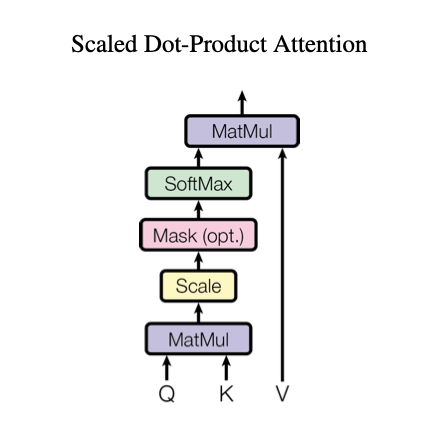

In [4]:
def scaled_dot_product_attention(q, k, v, mask=None, dropout=None):
    """
    Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimensions, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth_k)
    k: key shape == (..., seq_len_k, depth_k)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # apply the mask
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    
    # apply dropout
    if dropout is not None:
        weights = dropout(weights)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [5]:
# define the hyperparameters
batch_size = 128
seq_len_q = 32
seq_len_k = 16
depth_k = 64
depth_v = 128

# define the input tensors
query = tf.random.normal((batch_size, seq_len_q, depth_k))
key = tf.random.normal((batch_size, seq_len_k, depth_k))
value = tf.random.normal((batch_size, seq_len_k, depth_v))

print(f'Query tensor shape:\t{query.shape}')
print(f'Key tensor shape:\t{key.shape}')
print(f'Value tensor shape:\t{value.shape}')

# call the scaled dot-product operator
output, weights = scaled_dot_product_attention(query, key, value)

print(f'\nOutput tensor shape:\t{output.shape}')
print(f'Attention tensor shape:\t{weights.shape}')

Query tensor shape:	(128, 32, 64)
Key tensor shape:	(128, 16, 64)
Value tensor shape:	(128, 16, 128)

Output tensor shape:	(128, 32, 128)
Attention tensor shape:	(128, 32, 16)


### Multi-Head Attention

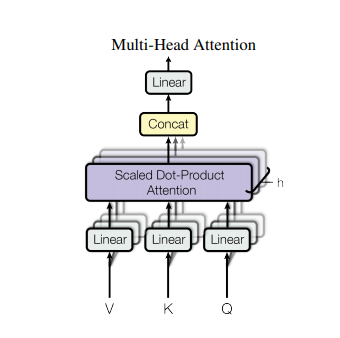

In [6]:
class MultiHeadAttention(tfkl.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tfkl.Dense(d_model)
        self.wk = tfkl.Dense(d_model)
        self.wv = tfkl.Dense(d_model)
        
        self.dense = tfkl.Dense(d_model)
        
    def scaled_dot_product_attention(self, q, k, v, mask, dropout):
        """
        Calculate the attention weights.
        q, k, v must have matching leading dimensions.
        k, v must have matching penultimate dimensions, i.e.: seq_len_k = seq_len_v.
        The mask has different shapes depending on its type(padding or look ahead) 
        but it must be broadcastable for addition.
        
        Args:
        q: query shape == (..., seq_len_q, depth_k)
        k: key shape == (..., seq_len_k, depth_k)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.
        
        Returns:
        output, attention_weights
        """
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
        
        # scale matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        # apply the mask
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)  
        
        # softmax is normalized on the last axis (seq_len_k)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

        # apply dropout
        if dropout is not None:
            weights = dropout(weights)
        
        output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
        
        return output, attention_weights
    
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask=None, dropout=None):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask, dropout)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

In [ ]:
# define the hyperparameters
batch_size = 128
seq_len = 64
depth = 256
heads = 8
d_model = 512

# instantiate the class
multi_head_attention = MultiHeadAttention(d_model=d_model, num_heads=heads)

# define the input tensors
query = tf.random.normal((batch_size, seq_len, depth))
key = tf.random.normal((batch_size, seq_len, depth))
value = tf.random.normal((batch_size, seq_len, depth))

print(f'Query tensor shape:\t{query.shape}')
print(f'Key tensor shape:\t{key.shape}')
print(f'Value tensor shape:\t{value.shape}')

# call the multi-head attention layer
output, weights = multi_head_attention(query, key, value)

print(f'\nOutput tensor shape:\t{output.shape}')
print(f'Attention tensor shape:\t{weights.shape}')

Query tensor shape:	(128, 64, 256)
Key tensor shape:	(128, 64, 256)
Value tensor shape:	(128, 64, 256)

Output tensor shape:	(128, 64, 512)
Attention tensor shape:	(128, 8, 64, 64)
